In [1]:
from kedro_datasets.pandas import ParquetDataset
import pandas as pd

#kobe_raw_dev = catalog.load(name='kobe_raw_dev@parquet')
pd.options.display.max_columns = None
pd.options.display.max_rows = None
dataset = ParquetDataset(filepath='../data/01_raw/dataset_kobe_dev.parquet').load()

In [2]:
dataset = dataset.drop(columns=['action_type','combined_shot_type','game_event_id','game_id','loc_x','loc_y','season','seconds_remaining','shot_type','shot_zone_area','shot_zone_basic','shot_zone_range','team_id','team_name','game_date','matchup','opponent','shot_id'])

In [3]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 24271 entries, 0 to 30696
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   lat                24271 non-null  float64
 1   lon                24271 non-null  float64
 2   minutes_remaining  24271 non-null  int64  
 3   period             24271 non-null  int64  
 4   playoffs           24271 non-null  int64  
 5   shot_distance      24271 non-null  int64  
 6   shot_made_flag     20285 non-null  float64
dtypes: float64(3), int64(4)
memory usage: 1.5 MB


In [4]:
dataset = dataset.dropna()

In [5]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20285 entries, 1 to 30696
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   lat                20285 non-null  float64
 1   lon                20285 non-null  float64
 2   minutes_remaining  20285 non-null  int64  
 3   period             20285 non-null  int64  
 4   playoffs           20285 non-null  int64  
 5   shot_distance      20285 non-null  int64  
 6   shot_made_flag     20285 non-null  float64
dtypes: float64(3), int64(4)
memory usage: 1.2 MB


In [6]:
dataset = dataset.dropna()

In [7]:
dataset.head()


,lat,lon,minutes_remaining,period,playoffs,shot_distance,shot_made_flag
1,34.0443,-118.4268,10,1,0,15,0.0
2,33.9093,-118.3708,7,1,0,16,1.0
3,33.8693,-118.1318,6,1,0,22,0.0
4,34.0443,-118.2698,6,2,0,0,1.0
5,34.0553,-118.4148,9,3,0,14,0.0


In [ ]:
from pycaret.classification import *
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

In [9]:
experiment = ClassificationExperiment()
experiment.setup(
    data=dataset, 
    target='shot_made_flag', 
    log_experiment='mlflow',
    experiment_name='kobe_pycarret'
)

,Description,Value
0,Session id,6105
1,Target,shot_made_flag
2,Target type,Binary
3,Original data shape,"(20285, 7)"
4,Transformed data shape,"(20285, 7)"
5,Transformed train set shape,"(14199, 7)"
6,Transformed test set shape,"(6086, 7)"
7,Numeric features,6
8,Preprocess,True
9,Imputation type,simple


In [10]:
experiment.get_metrics()

,Name,Display Name,Score Function,Scorer,Target,Args,Greater is Better,Multiclass,Custom
ID,,,,,,,,,
acc,Accuracy,Accuracy,<function accuracy_score at 0x0000015EBFB740E0>,accuracy,pred,{},True,True,False
auc,AUC,AUC,<pycaret.internal.metrics.BinaryMulticlassScor...,"make_scorer(roc_auc_score, response_method=('d...",pred_proba,"{'average': 'weighted', 'multi_class': 'ovr'}",True,True,False
recall,Recall,Recall,<pycaret.internal.metrics.BinaryMulticlassScor...,"make_scorer(recall_score, response_method='pre...",pred,{'average': 'weighted'},True,True,False
precision,Precision,Prec.,<pycaret.internal.metrics.BinaryMulticlassScor...,"make_scorer(precision_score, response_method='...",pred,{'average': 'weighted'},True,True,False
f1,F1,F1,<pycaret.internal.metrics.BinaryMulticlassScor...,"make_scorer(f1_score, response_method='predict...",pred,{'average': 'weighted'},True,True,False
kappa,Kappa,Kappa,<function cohen_kappa_score at 0x0000015EBFB74...,"make_scorer(cohen_kappa_score, response_method...",pred,{},True,True,False
mcc,MCC,MCC,<function matthews_corrcoef at 0x0000015EBFB74...,"make_scorer(matthews_corrcoef, response_method...",pred,{},True,True,False


In [ ]:
best = experiment.compare_models(n_select=15)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
ada,Ada Boost Classifier,0.5938,0.5988,0.3784,0.6231,0.4708,0.1718,0.1861,0.0440
gbc,Gradient Boosting Classifier,0.5914,0.5981,0.3845,0.6160,0.4733,0.1677,0.1804,0.0850
catboost,CatBoost Classifier,0.5802,0.5904,0.4448,0.5793,0.5030,0.1502,0.1544,1.9330
lda,Linear Discriminant Analysis,0.5769,0.6000,0.4852,0.5663,0.5226,0.1468,0.1483,0.0050
ridge,Ridge Classifier,0.5768,0.6000,0.4848,0.5662,0.5223,0.1465,0.1480,0.0060
lr,Logistic Regression,0.5764,0.5989,0.4808,0.5663,0.5200,0.1456,0.1471,0.3760
qda,Quadratic Discriminant Analysis,0.5757,0.6010,0.5279,0.5588,0.5429,0.1476,0.1478,0.0060
lightgbm,Light Gradient Boosting Machine,0.5748,0.5862,0.4487,0.5699,0.5019,0.1400,0.1432,0.0660
nb,Naive Bayes,0.5734,0.5960,0.4982,0.5598,0.5272,0.1410,0.1418,0.0050
rf,Random Forest Classifier,0.5629,0.5740,0.5335,0.5432,0.5381,0.1233,0.1234,0.1570


2025/04/01 19:03:11 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.
2025/04/01 19:03:12 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.
2025/04/01 19:03:12 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.
2025/04/01 19:03:13 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.
2025/04/01 19:03:13 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.
2025/04/01 19:03:13 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when

[AdaBoostClassifier(algorithm='SAMME.R', estimator=None, learning_rate=1.0,
                    n_estimators=50, random_state=6105),
 GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                            learning_rate=0.1, loss='log_loss', max_depth=3,
                            max_features=None, max_leaf_nodes=None,
                            min_impurity_decrease=0.0, min_samples_leaf=1,
                            min_samples_split=2, min_weight_fraction_leaf=0.0,
                            n_estimators=100, n_iter_no_change=None,
                            random_state=6105, subsample=1.0, tol=0.0001,
                            validation_fraction=0.1, verbose=0,
                            warm_start=False)]

In [ ]:
model_1 = None
model_2 = None

for model in best:
    if(isinstance(model, AdaBoostClassifier)):
        model_1 = model
    if(isinstance(model, DecisionTreeClassifier)):
        model_2 = model

True
False


In [13]:
experiment.evaluate_model(best)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [14]:
import pickle

with open('model.pkl', 'wb') as fout:
    pickle.dump(best, fout)

In [17]:
#experiment.plot_model(best, plot = 'residuals_interactive')

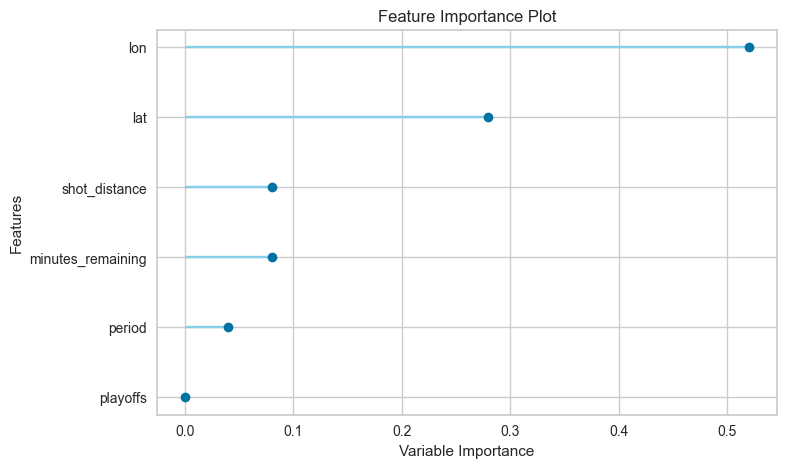

In [18]:
experiment.plot_model(best, plot = 'feature')

In [ ]:
final_best = experiment.finalize_model(best)

2025/04/01 18:55:14 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


In [ ]:
final_best

Pipeline(memory=Memory(location=None),
         steps=[('numerical_imputer',
                 TransformerWrapper(exclude=None,
                                    include=['lat', 'lon', 'minutes_remaining',
                                             'period', 'playoffs',
                                             'shot_distance'],
                                    transformer=SimpleImputer(add_indicator=False,
                                                              copy=True,
                                                              fill_value=None,
                                                              keep_empty_features=False,
                                                              missing_values=nan,
                                                              strategy='mean'))),
                ('categorical_imputer',
                 TransformerWrapper(exclude=None, include=[],
                                    transformer=SimpleImputer(add_indicator=False,
                                                              copy=True,
                                                              fill_value=None,
                                                              keep_empty_features=False,
                                                              missing_values=nan,
                                                              strategy='most_frequent'))),
                ('actual_estimator',
                 AdaBoostClassifier(algorithm='SAMME.R', estimator=None,
                                    learning_rate=1.0, n_estimators=50,
                                    random_state=6105))],
         verbose=False)